In [1]:
###from google.colab import drive
###drive.mount('/content/drive')

In [2]:
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter 
from scipy.io import savemat,loadmat
import random
import scipy as sp
import scipy.sparse as sparse
from numpy.linalg import matrix_power
from scipy.sparse.linalg import eigsh,eigs
import matplotlib.pyplot as plt
import os

In [3]:
filepath="/Users/mcroning/Anaconda/"
!cd '/Users/mcroning/Anaconda' 

In [4]:
def makesparse(A):
    M=[]
    M=A
    M=sparse.csr_matrix(np.where(abs(M)<1e-10,0,A))
    return M

In [5]:
geomold=[]
storenoiseold=False
if os.path.exists("prdata.mat"):
    prdata=loadmat("prdata.mat",simplify_cells=True)
    geomold=tuple(prdata['geom'])
    if 'storenoise' in prdata:
        storenoiseold=prdata['storenoise']
    else:
        storenoiseold=False

#fundamental constants
q= 1.602e-19 # charge on electron
kB= 1.38e-23 # Boltzmanns constant
eps0 = 8.85e-12 #permittivity of free space

#material and environmental parameters
refin = 2.4 #refractive index
noiseamp = 0 #noise (scattering) amplitude
Id = 0.1 # equivalent dark intensity to represent themally excited carriers
sigma = 2.0 #scattering correlation length
gl = 0  #coupling constant length product, typically 2~3 in BaTi03
T = 293.0 #temperature K
NT= 6.4e22 #Bati03 trap density
epsr= 2500 #relative dielectric permittivity

#grid parameters
xaper=2000 # xaperture microns
yaper=1000 # yaper
xsamp=2048 # number of samples in x
ysamp=256  # number of samples in y
rlen= 5000 # crystal (medium) length
dz= 50     # step size
dz_frac=0.001  # internal step for calc of z derivative of field norm to intrnal wavelength
geom=(xaper,yaper,xsamp,ysamp,rlen,dz) # tuple to check for grid changes to dee if new noise and coords needed
windowedge = 0.1 #Tukey widow edge parameter
niter=int(rlen/dz)
x=np.linspace(-xaper/2,xaper/2,xsamp)
y=np.linspace(-yaper/2,yaper/2,ysamp)
z=np.linspace(0,rlen,niter)





#optical parameters
lm= 0.625 # wavelength
w01= 200 #beam 1 waist 
w02= 200 #beam 2 waist 
thout1=0.16 #external angle of incidence of beam 1
thout2=-0.16 #external angle of incidence of beam 2
phi1= 0.0 #beam 1 azimuth
phi2 = 0.0 # beam 2 azimuth
rat = 1 # beam intensity ratio
th1=np.arcsin(np.sin(thout1)/refin)
th2=np.arcsin(np.sin(thout2)/refin)
dz_small=lm/refin*dz_frac
#calcualtion switches
transp1 = False # switch to True to apply input image to beam 1
transp2 = False # switch to True to apply input image to beam 2
loc= 'PyPy', #set location of diffraction operator in nonparaxial BPM P for exact operator
test_sharma=False # switch nonparaxial BPM to toy instance from Sharma paper
storenoise=False #anticipate using scattering noise in calcs
newnoise=((geom!=geomold) or storenoise!=storenoiseold) and storenoise #regenerate noise array, eg if 
pml=False # True if using perfectle matched layers
mode='fft' #fdbpm or fft or fdbpm nonparaxial or Gaussian Analytical

prdata={
    'q':q,
    'kB':kB,
    'eps0':eps0,
    'epsr':epsr,
    'NT':NT,
    'T':T,
    'refin': refin,
    'noiseamp': noiseamp,
    'Id':Id,
    'sigma':sigma,
    'gl': gl,
    'xaper':xaper,
    'yaper':yaper,
    'xsamp':xsamp,
    'ysamp':ysamp,
    'rlen': rlen,
    'dz' : dz,
    'dz_frac':dz_frac,
    'windowedge':windowedge,
    'geom':geom,
    'lm':lm,
    'w01':w01,
    'w02':w02,
    'thout1':thout1,
    'thout2':thout2,
    'phi1':phi1,
    'phi2':phi2,
    'rat':rat,
    'mode':mode,
    'transp1':transp1,
    'transp2':transp2,
    'loc':loc,
    'storenoise':storenoise,
    'corrnoise':[[]]
    
    
}


In [6]:
def show(x):
    print(type(x),x.dtype,np.shape(x))

In [7]:
#type(dz_small)

In [8]:
corrnoise=np.random.rand(niter,xsamp,ysamp)-0.5

In [9]:
# of samples in  transverse x and y
#sharma test parameters
if test_sharma:
    x=np.linspace(-xaper/2,xaper/2,xsamp)
    y=np.linspace(-yaper/2,yaper/2,ysamp)
    z=np.linspace(0,rlen,niter)
    xsamp=60*8
    ysamp=40*8
    xaper=25*8
    yaper=33*8
    dz=10 #.1
    lm=1
    refin=1.0  #1.45
    thout1= 25*np.pi/180.0
    thout2= 25*np.pi/180.0
    rlen=80*8
    w01=2*8
    w02=2*8
    rat=0
    niter=int(rlen/dz)
    
    prdata['niter']=niter
    prdata['xsamp']=xsamp
    prdata['ysamp']=ysamp
    prdata['xaper']=xaper
    prdata['yaper']=yaper
    prdata['dz']=dz
    prdata['lm']=lm
    prdata['refin']=refin
    prdata['thout1']= thout1
    prdata['thout2']= thout2
    prdata['rlen']=rlen
    prdata['w01']=w01
    prdata['w02']=w02
    prdata['rat']=rat
#####

dx=xaper/xsamp
dy=yaper/ysamp
dX=1/xaper
dY=1/yaper
dxy=dx*dy
dXY=dX*dY
xy=xsamp*ysamp

#prdata['dX']=dX
#prdata['dY']=dY
#prdata['dxy']=dxy
#prdata['dXY']=dXY
#prdata['xy']=xy

In [10]:


# no space charge field in y direction right now

#data_in_size um
data_in_size=w01
prdata['data_in_size']=int(data_in_size)
kin=2*np.pi*refin/lm
#max angle of incidence
sn=2*np.pi*xsamp/(kin*xaper)
if sn>1.0:
      sn=1.0
thmax=np.arcsin(sn)


# from Garrett and Warde JOSAB 9 1407 1992
# photorefractive characteristic grating wavenumber

# characteristic space charge field (See CG whole beam method paper)

# effective electrooptic coefficient corresponding to specified gl coupling constant length product
#prdata['reff']=2*gl*lm/(rlen*np.pi*refin**3*Es)

# set up arrays of coodinates

# x and y frequency space in natural fft space frequency zero at array[0]
fx1=np.linspace(0,(xsamp/2-1)/(xaper),int(xsamp/2))
fx2=np.linspace(-xsamp/2/(xaper),-1.0/xaper,int(xsamp/2))
fx=np.concatenate((fx1,fx2))
#prdata['fx']=fx
fy1=np.linspace(0,(ysamp/2-1)/(yaper),int(ysamp/2))
fy2=np.linspace(-ysamp/2/(yaper),-1.0/yaper,int(ysamp/2))
fy=np.concatenate((fy1,fy2))
#prdata['fy']=fy



fxy=np.zeros((xsamp,ysamp),dtype="float")

# optical propagator


#2D fxy for esc calculation

for j in range(xsamp):
    for k in range(ysamp):
        fxy[j,k]=(fx[j]**2+fy[k]**2);

# basic kukhtarev space charge field not used yet



In [11]:
h=np.zeros((xsamp,ysamp),dtype="complex")
sqrarg=1-(lm/refin)**2*fxy
h = np.exp(2.0j*np.pi*refin*dz/lm*np.sqrt(1-(lm/refin)**2*(fxy)))
prdata['h']=h


In [12]:
##tukey window
#windowx=[]
#windowy=[]
#windowedge=prdata['windowedge']
windowx = signal.windows.tukey(xsamp,alpha=windowedge)
windowy = signal.windows.tukey(ysamp,alpha=windowedge)
windowxy=np.outer(windowx,windowy)
fwindowxy=np.fft.fftshift(windowxy)

#prdata['windowxy']=windowxy
#prdata['fwindowxy']=fwindowxy


In [13]:
#pseudorandom 3D noise array, uniform between -0.5 and 0.5


In [14]:
#sigma, noise correlation length microns, noiseamp amplitude of scatterers
#sigmax,y,x corresponding correlation length in terms of array units
#sigma=prdata['sigma']
sigmax=sigma*xsamp/xaper
sigmay=sigma*ysamp/yaper
sigmaz=sigma*niter/rlen

In [15]:
if storenoise==True:
    if newnoise==True:
        corrnoise=np.random.rand(niter,xsamp,ysamp)-0.5
        corrnoise=gaussian_filter(corrnoise,sigma=(sigmaz,sigmax,sigmay))
        corrnoise1layer=corrnoise[0,:]
        np.savez(filepath+'corrnoise1layer.npz',corrnoise1layer)
        np.savez(filepath+'corrnoise.npz',corrnoise)
        
    else:
        corrnoise1layer=np.load(filepath+'corrnoise1layer.npz')['arr_0']
        corrnoise=np.load(filepath+'corrnoise.npz')['arr_0']
    prdata['corrnoise1layer']=corrnoise1layer
    prdata['corrnoise']=corrnoise


In [16]:
# define two crossing input gaussians

In [17]:
# input beam amplitudes based on beam ratio


In [18]:
bwidth=.1
nxp=int(bwidth*xsamp)
def Fn(j,nxb,nxp,p0,x):
    
    d=x[nxb]-x[nxp]
    arg=np.pi*(x[nxp]-x[j])/d
    f=-64/(8j+3*p0-4*p0*np.cos(arg)+p0*np.cos(2*arg))**2
    return f
def Gn(j,nxb,nxp,p0,x):
    
    d=x[nxb]-x[nxp]
    arg=np.pi*(x[nxp]-x[j])/d
    g=128*p0*(np.pi*np.sin(arg))**2*(8*(p0-2j)-(32j+9*p0)*np.cos(arg)+p0*np.cos(3*arg))/(d*(8j+3*p0-4*p0*np.cos(arg)+p0*np.cos(2*arg))**2)**2
    return g
def hh(j,nxb,nxp,p0,x):
    
    d=x[nxb]-x[nxp]
    arg=np.pi*(x[nxp]-x[j])/d
    h=x[j]-1j/16*p0*(6*x[j]-6*x[nxp]-d/np.pi*(-8*np.sin(arg)+np.sin(2*arg)))
    return h
def F1n(j,nxb,nxp,p0,x):
    
    d=x[nxb]-x[nxp]
    arg=np.pi*(x[nxp]-x[j])/d
    f=8j/(8j+3*p0-4*p0*np.cos(arg)+p0*np.cos(2*arg))
    return f 
   

In [19]:
Fd=np.ones(xsamp,dtype='complex')
Gd=np.zeros(xsamp,dtype='complex')
xd=x.astype(complex) #stretched x for pml
p0=0.1
for j in range(nxp+1):
    Fd[j]=(Fn(j,0,nxp,p0,x))
    Gd[j]=(Gn(j,0,nxp,p0,x))
    xd[j]=np.conj(hh(j,0,nxp,p0,x))
for j in range(xsamp-1-nxp,xsamp):
    Fd[j]=(Fn(j,xsamp-1,xsamp-1-nxp,p0,x))
    Gd[j]=(Gn(j,xsamp-1,xsamp-1-nxp,p0,x))
    xd[j]=np.conj(hh(j,xsamp-1,xsamp-1-nxp,p0,x))
F=np.diag(Fd)
F=np.conj(F)
G=np.diag(Gd)
G=np.conj(G)


In [20]:

xp1=np.zeros((xsamp,ysamp),dtype=complex)
yp1=np.zeros((xsamp,ysamp),dtype=complex)
zp1=np.zeros((xsamp,ysamp),dtype=complex)
xp2=np.zeros((xsamp,ysamp),dtype=complex)
yp2=np.zeros((xsamp,ysamp),dtype=complex)
zp2=np.zeros((xsamp,ysamp),dtype=complex)

xp1dz=np.zeros((xsamp,ysamp),dtype=complex)
yp1dz=np.zeros((xsamp,ysamp),dtype=complex)
zp1dz=np.zeros((xsamp,ysamp),dtype=complex)
xp2dz=np.zeros((xsamp,ysamp),dtype=complex)
yp2dz=np.zeros((xsamp,ysamp),dtype=complex)
zp2dz=np.zeros((xsamp,ysamp),dtype=complex)

#empirical correction extra division by 2
el=rlen/2.0

#x=xd #temp switch x to stretched

sp1=np.sin(phi1)
cp1=np.cos(phi1)
st1=np.sin(th1)
ct1=np.cos(th1)
sp2=np.sin(phi2)
cp2=np.cos(phi2)
st2=np.sin(th2)
ct2=np.cos(th2)


for j in range(xsamp):
     for k in range(ysamp):                     
        xp1[j,k]=1/2*(x[j]+x[j]*cp1**2*(-1+2*ct1)+x[j]*sp1**2+y[k]*np.sin(2*phi1)+cp1*(-2*y[k]*ct1*sp1+2*(-el)*st1))
        yp1[j,k]=1/2*(y[k]+cp1**2*(y[k]-y[k]*ct1)-2*x[j]*cp1*ct1*sp1-y[k]*sp1**2+y[k]*ct1*(1+sp1**2)+x[j]*np.sin(2*phi1)-2*(-el)*sp1*st1)
        zp1[j,k]=(-el)*ct1+(-x[j]*cp1+y[k]*sp1)*st1
        
        xp1dz[j,k]=1/2*(x[j]+x[j]*cp1**2*(-1+2*ct1)+x[j]*sp1**2+y[k]*np.sin(2*phi1)+cp1*(-2*y[k]*ct1*sp1+2*(-el+dz_small)*st1))
        yp1dz[j,k]=1/2*(y[k]+cp1**2*(y[k]-y[k]*ct1)-2*x[j]*cp1*ct1*sp1-y[k]*sp1**2+y[k]*ct1*(1+sp1**2)+x[j]*np.sin(2*phi1)-2*(-el+dz_small)*sp1*st1)
        zp1dz[j,k]=(-el+dz_small)*ct1+(-x[j]*cp1+y[k]*sp1)*st1
        
        xp2[j,k]=1/2*(x[j]+x[j]*cp2**2*(-1+2*ct2)+x[j]*sp2**2+y[k]*np.sin(2*phi2)+cp2*(-2*y[k]*ct2*sp2+2*(-el)*st2))
        yp2[j,k]=1/2*(y[k]+cp2**2*(y[k]-y[k]*ct2)-2*x[j]*cp2*ct2*sp2-y[k]*sp2**2+y[k]*ct2*(1+sp2**2)+x[j]*np.sin(2*phi2)-2*(-el)*sp2*st2)
        zp2[j,k]=(-el)*ct2+(-x[j]*cp2+y[k]*sp2)*st2
        
        xp2dz[j,k]=1/2*(x[j]+x[j]*cp2**2*(-1+2*ct2)+x[j]*sp2**2+y[k]*np.sin(2*phi2)+cp2*(-2*y[k]*ct2*sp2+2*(-el+dz_small)*st2))
        yp2dz[j,k]=1/2*(y[k]+cp2**2*(y[k]-y[k]*ct2)-2*x[j]*cp2*ct2*sp2-y[k]*sp2**2+y[k]*ct2*(1+sp2**2)+x[j]*np.sin(2*phi2)-2*(-el+dz_small)*sp2*st2)
        zp2dz[j,k]=(-el+dz_small)*ct2+(-x[j]*cp2+y[k]*sp2)*st2
        

prdata['xp1']=xp1
prdata['yp1']=yp1
prdata['zp1']=zp1
prdata['xp1dz']=xp1dz
prdata['yp1dz']=yp1dz
prdata['zp1dz']=zp1dz
prdata['xp2']=xp2
prdata['yp2']=yp2
prdata['zp2']=zp2
prdata['xp2dz']=xp2dz
prdata['yp2dz']=yp2dz
prdata['zp2dz']=zp2dz


In [21]:
phi2

0.0

In [22]:

korder=100
order=12
a=np.zeros(korder)
b=np.zeros(korder)
kin=prdata['refin']*2*np.pi/prdata['lm']
a[1]=1
for m in range(1,korder-1):
       a[m+1]=-a[m]*(2*m-1)**2/(2*m*(2*m+1))
for k in range(1,korder-1):
    b[k]=(1/4**(k-1))*sum(a[m]*a[k-m+1] for m in range(k+1))
Dx=sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(xsamp, xsamp)).toarray()
Dy=sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(ysamp, ysamp)).toarray()
A=sum(b[j]*matrix_power(-Dx,j) for j in range(1,order+1))/dx**2
B=sum(b[j]*matrix_power(-Dy,j) for j in range(1,order+1))/dy**2

In [23]:

if pml:

    #S=A1+np.diag(Gd)
    #vals,vecs=np.linalg.eig(S)
    vals,vecs=np.linalg.eig(F@A)   ### now replace Dx by F@A
    idx = vals.argsort()[::-1]   
    vals = vals[idx]
    vecs = vecs[:,idx]
    Lx=vals
    Vx=vecs
    Vxinv=np.linalg.inv(Vx)
    #Odx=-sum(b[j]*(-Lx)**j for j in range(1,order+1))/dx**2+(kin)**2*np.ones(xsamp)
    Odx=-vals-np.conj(Gd)+(kin)**2*np.ones(xsamp) #+-
    #Odx=-vals+(kin)**2*np.ones(xsamp)
else:    
    dz=-dz
    Lx=np.zeros(xsamp)
    Vx=np.zeros((xsamp,xsamp))
    for i in range(xsamp):
        Lx[i]=4*np.sin((i+1)*np.pi/(2*xsamp+2))**2
        for j in range(xsamp):
            Vx[i,j]=np.sqrt(2/(xsamp+1))*np.sin((i+1)*(j+1)*np.pi/(xsamp+1))
    Vxinv=Vx    
    Odx=-sum(b[j]*(-Lx)**j for j in range(1,order+1))/dx**2+(kin)**2*np.ones(xsamp)

Ly=np.zeros(ysamp)
Vy=np.zeros((ysamp,ysamp))
for i in range(ysamp):
    Ly[i]=4*np.sin((i+1)*np.pi/(2*ysamp+2))**2
    for j in range(ysamp):
        Vy[i,j]=np.sqrt(2/(ysamp+1))*np.sin((i+1)*(j+1)*np.pi/(ysamp+1))
        
Oy=sum(b[j]*(-Ly)**j for j in range(1,order+1))/dy**2


Ody=(kin)**2*np.ones(ysamp)-Oy
Ov11y=np.diag(np.cos(np.sqrt(Ody)*dz)) #do full step instead of 1/2)
Ov22y=Ov11y
Ov12y=np.diag(np.sin(np.sqrt(Ody)*dz)/np.sqrt(Ody))
Ov21y=-np.diag(np.sin(np.sqrt(Ody)*dz)*np.sqrt(Ody))

Py11=Vy@Ov11y@Vy
Py22=Vy@Ov22y@Vy
Py21=Vy@Ov21y@Vy
Py12=Vy@Ov12y@Vy

#Odx=(kin)**2*np.ones(xsamp)-Ox #diagonal
Ov11x=np.diag(np.cos(np.sqrt(Odx)*dz))
Ov22x=Ov11x
Ov12x=np.diag(np.sin(np.sqrt(Odx)*dz)/np.sqrt(Odx))
Ov21x=-np.diag(np.sin(np.sqrt(Odx)*dz)*np.sqrt(Odx))

Px11=Vx@Ov11x@Vxinv
Px22=Vx@Ov22x@Vxinv
Px21=Vx@Ov21x@Vxinv
Px12=Vx@Ov12x@Vxinv

Px11=makesparse(Px11)
Px12=makesparse(Px12)
Px21=makesparse(Px21)
Px22=makesparse(Px22)
Py11=makesparse(Py11)
Py12=makesparse(Py12)
Py21=makesparse(Py21)
Py22=makesparse(Py22)

Px=[[Px11,Px12],[Px21,Px22]]
Py=[[Py11,Py12],[Py21,Py22]]


prdata['A']=makesparse(A)
prdata['B']=makesparse(B)
prdata['Px']=Px
prdata['Py']=Py


if pml==False:
    dz=-dz
    
savemat("prdata.mat", prdata)

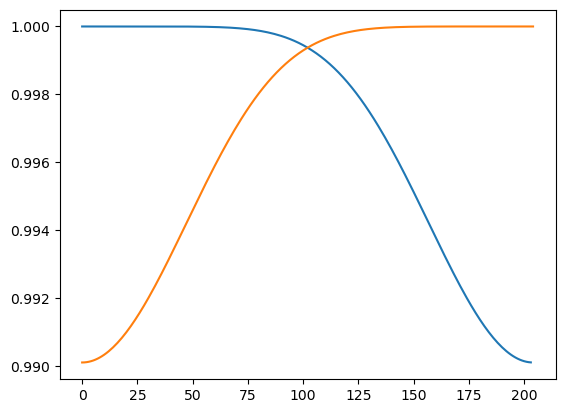

In [24]:
plt.plot(abs(Fd[xsamp-nxp-1:xsamp-1]))
plt.plot(abs(Fd[:nxp+1]))

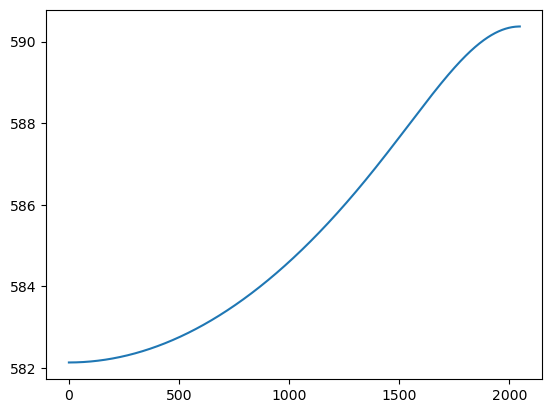

In [25]:
plt.plot(abs(Odx))

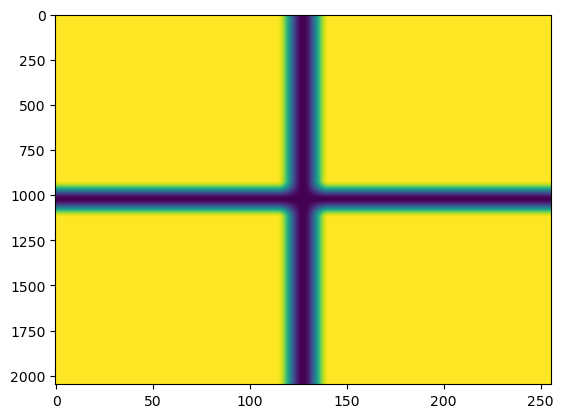

In [26]:
plt.imshow(fwindowxy,aspect='auto')

In [27]:
prdata['data_in_size']

200

In [28]:
for key in prdata.keys():
    print(key)

q
kB
eps0
epsr
NT
T
refin
noiseamp
Id
sigma
gl
xaper
yaper
xsamp
ysamp
rlen
dz
dz_frac
windowedge
geom
lm
w01
w02
thout1
thout2
phi1
phi2
rat
mode
transp1
transp2
loc
storenoise
corrnoise
data_in_size
h
xp1
yp1
zp1
xp1dz
yp1dz
zp1dz
xp2
yp2
zp2
xp2dz
yp2dz
zp2dz
A
B
Px
Py
